# Recurrent Neural Networks

In this notebook, we will get familiar with recurrent neural networks (RNNs) - a neural network structure designed to handle sequential data like time series.

**Learning Objectives**

1. Describe the structure of an RNN and how its structure is used for time series data
2. Implement an RNN in PyTorch.
3. Interpret differences in RNN performance based on window size.

**Import modules**

Begin by importing the modules to be used in this notebook.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
torch.manual_seed(42)

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


## Motivation

In previous examples with neural networks, we have treated all of our samples as independent - for example, one image of of a hand-drawn image or a sea creature did not depend on the sample before it. However, there are some datasets for which this doesn't work so well. For example, consider creating a model to predict the temperature on the next day. This is going to depend on the information that came before it - perhaps there is a heat wave or a cold snap.

A Recurrent Neural Network (RNN) is a type of neural network designed to process sequential data. It can be used for various types of sequence data such as time series, speech, or text. Unlike traditional "feed-forward" networks that consider independent samples, RNNs have loops that allow information to persist across sequence components or time steps. This means the network can use its internal memory - termed the "hidden state" - to capture context from earlier inputs when processing later ones. 

## Implementing Recurrence into a Neural Network

To understand the idea of recurrence, let's first take a look at the structure of a "feed-forward" network that we have seen previously:

![Feed Forward Neural Network](FFNN_Schematic.png)

In this type of network, the weights of the hidden layer(s) are updated with each batch of data. For example, if there is only a single layer, the model is as follows:

$$
y = \sigma ( w^Tx + b)
$$

In this structure, the model has no memory of what led to the update of the weights. Thus, each set of input features provided for training can modify the model independently without directly being influenced by previous input features. To remedy this memory issue, we can add in a recursive component to the network to make it a **recurrent neural network**. Let's take a look at the following schematic:

![Feed Forward Neural Network](RNN_Schematic.png)

In this netowork architecture, let's consider the second forward pass where $y_2$ is estimated from $x_2$. In this step, we modify the previous model by *including the previous weights and hidden layer in the linear combination step* as follows:

$$
y^{(t)} = \sigma ( w_{xh}^Tx^{(t)} + b + w_{hh}^Th^{(t-1)})
$$


Here, the $w_{xh}^Tx^{(t)} + b$ is identical to the feed-forward case where $w_{xh}$ is used to indicate the weight matrix connecting the input features to the hidden layer and the $x^{(t)}$ is the input features at time $t$ in the sequence. However, we also see that **there is an additional set of weights $w_{hh}$ applied to the previous hidden layer $h^{(t-1)}$**. This is the key mechanism of recurrence and it allows our model to learn from both present and past input features.


### Training an RNN: Backpropagation Through Time

The recurrent mechanism allows us to use information in our previous hidden states when updating the present weights. However, this also implies that our losses will also depend on the values of the hidden state - not just the present state and input features. To compute these losses, we will need to consider all of the previous losses through time:

$$
L = \sum_{t=1}^T L^{(t)}
$$

Since our loss function depends on all of the losses through time, this means that when we compute the derivatives of the loss with respect to the weights, we also need to consider the previous hidden states. We can write this as follows:

$$
\frac{\partial L^{(t)}}{\partial w_{hh}} = \frac{\partial L^{(t)}}{\partial y^{(t)}} \cdot \frac{\partial y^{(t)}}{\partial h^{(t)}} \cdot \left( \sum_{k=1}^t \frac{\partial h^{(t)}}{\partial h^{(k)}} \cdot \frac{\partial h^{(k)}}{\partial w_{hh}}\right)
$$

It is important to note here that the $\frac{\partial h^{(t)}}{\partial h^{(k)}}$ in the sum is a multiplication of gradients between times $k$ and $t$ i.e.

$$
\frac{\partial h^{(t)}}{\partial h^{(k)}} = \prod_{i=k+1}^t \frac{\partial h^{(i)}}{\partial h^{(i-1)}}
$$

This final point will become important layer when we discuss the nuances of training the network.

## An example dataset: Temperature in Fairbanks Alaska

As our first RNN example, we'll consider a timeseries of maximum daily temperature in Fairbanks, Alaska. We can read in this dataset with the provided file as follows:

In [5]:
data = pd.read_csv("Fairbanks_Historical_Meteorological_Data.csv")
temps = (data["Max_Temperature"].values.reshape(-1, 1)+data["Min_Temperature"].values.reshape(-1, 1))/2

This dataset is very long - more than 100 years - so let's limit this to just 10 years for this example:

In [6]:
years = 10

In [7]:
temps = temps[-years*365:]

Let's have a peek at this data:

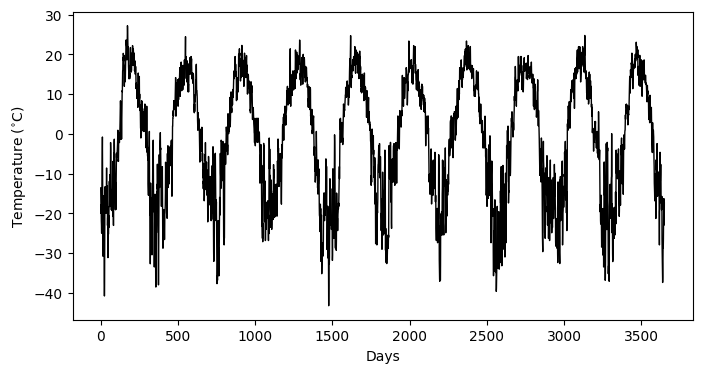

In [8]:
fig = plt.figure(figsize=(8,4))
plt.plot(temps, 'k-', linewidth=1)
plt.ylabel('Temperature ($^{\\circ}$C)')
plt.xlabel('Days')
plt.show()

As we can see, there is an annual seasonal cycle, but also plenty of interannual variability with some days and seasonal that vary from the mean.

The question we are interested in here is: **given a record of temperature over a given time period (e.g. 30 days), can we predict the next week of weather?**

Since this time series has a strong seasonal cycle, any model is going to be easier to train and be more reliable if we consider anomalies relative to a seasonal *climatology*. Let's compute that and here:

In [9]:
# compute a climatology assuming all years have 365 days
climatology = np.zeros((365,))
for year in range(years):
    climatology += temps[year*365:(year+1)*365, 0]
climatology /= years

Then, the anomalies will be computed by how far the temperature deviates from the climatology:

In [10]:
# make time series for anomalies and the climatology to fill in
temps_anomaly = np.zeros_like(temps)
temps_clim = np.zeros_like(temps)

# construct the timeseries in each year
for year in range(years):
    temps_anomaly[year*365:(year+1)*365, 0] = temps[year*365:(year+1)*365, 0] - climatology
    temps_clim[year*365:(year+1)*365, 0] = climatology

Let's have a look:

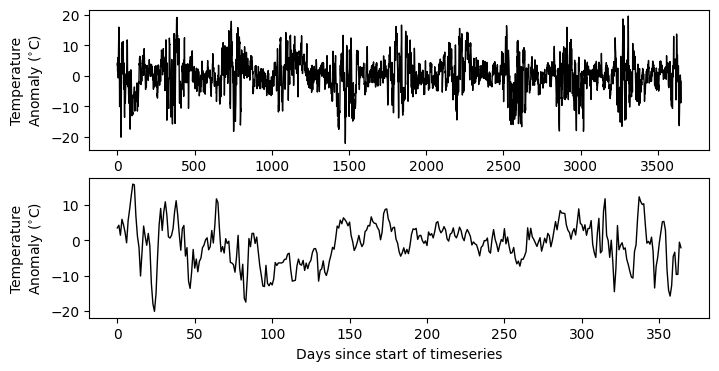

In [11]:
fig = plt.figure(figsize=(8,4))

# plto the anomalies
plt.subplot(2,1,1)
plt.plot(temps_anomaly, 'k-', linewidth=1)
plt.ylabel('Temperature\nAnomaly ($^{\\circ}$C)')

# plot the anomalies in the first year only
plt.subplot(2,1,2)
plt.plot(temps_anomaly[:365], 'k-', linewidth=1)
plt.ylabel('Temperature\nAnomaly ($^{\\circ}$C)')
plt.xlabel('Days since start of timeseries')
plt.show()

As we can see above, the anomalies are coherent temporally - that is, if one day is colder than normal, then there is a good chance the next day is colder than normal as well. This memory of past events is one thing we would like to build into our predictions.

In one final update, let's normalize our temperature data to a standard range:

In [12]:
# normalize the data
mean_temp = np.mean(temps_anomaly)
std_temp = np.std(temps_anomaly)
temps_anomaly_scaled = (temps_anomaly - mean_temp) / std_temp

As always, let's visualize our data so we know what it looks like:

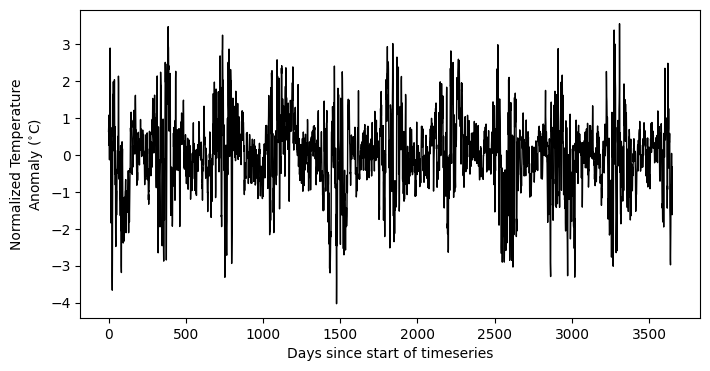

In [13]:
# plot the nomalized data
fig = plt.figure(figsize=(8,4))
plt.plot(temps_anomaly_scaled, 'k-', linewidth=1)
plt.ylabel('Normalized Temperature\nAnomaly ($^{\\circ}$C)')
plt.xlabel('Days since start of timeseries')
plt.show()

## Preparing the training sequences

In this example, we're going to make a model to predict the temperature of upcoming days based on temperatures from the past. Thus, we'll need to create a set of sequences from our existing data and corresponding set of single temperatures for the next day:

In [14]:
# define the number of previous days to store in the sequence:
n_previous_days = 30
n_future_days = 7

# make sequences
X, y = [], []
for i in range(len(temps_anomaly_scaled) - n_previous_days-n_future_days):
    # subset and append sequences
    X.append(temps_anomaly_scaled[i:i+n_previous_days, 0])
    y.append(temps_anomaly_scaled[i+n_previous_days:i+n_previous_days+n_future_days, 0])
 
# stack, then check the shapes of X and y
X = np.stack(X)
y = np.stack(y)
print(np.shape(X), np.shape(y))

(3613, 30) (3613, 7)


We can visualize one of these as follows:

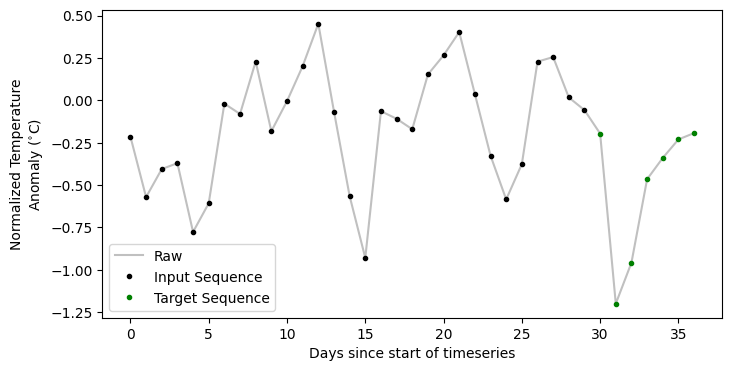

In [15]:
# choose a random sample
sample_index = 500

fig = plt.figure(figsize=(8,4))
plt.plot(temps_anomaly_scaled[sample_index:sample_index+n_previous_days+n_future_days],
         '-',color='silver',label='Raw')
plt.plot(np.arange(n_previous_days), X[sample_index,:],
         'k.', linewidth=1, label='Input Sequence')
plt.plot(np.arange(n_previous_days, n_previous_days + n_future_days),
         y[sample_index,:], 'g.', label='Target Sequence')
plt.ylabel('Normalized Temperature\nAnomaly ($^{\\circ}$C)')
plt.xlabel('Days since start of timeseries')
plt.legend()
plt.show()

To assess our model, we're going to need some training and testing data. Here, we will use the first 8 years of our timeseries as the training data and the final two as the testing data:

In [16]:
# creating training and testing set
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test   = X[split:], y[split:]

Finally, we'll need these to be PyTorch tensors and have a way to load these in our model, so let's convert these numpy arrays to tensors and make some `DataLoader` objects:

In [17]:
# convert to tensors
X_train_tensor = torch.tensor(X_train).float().unsqueeze(-1)
X_test_tensor = torch.tensor(X_test).float().unsqueeze(-1)
y_train_tensor = torch.tensor(y_train).float()
y_test_tensor = torch.tensor(y_test).float()

# determine a batch size
batch_size = 16

# make a TensorDataset object for the training data
ds_train = TensorDataset(X_train_tensor, y_train_tensor)

# make a loader object for the training data
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)

# make a TensorDataset object for the training data
ds_test = TensorDataset(X_test_tensor, y_test_tensor)

# make a loader object for the training data
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

## Building the RNN

Since RNNs are common tool, there is a PyTorch implementation of an RNN. Let's take a look at what this looks like

In [20]:
class TemperatureRNN(nn.Module):
    def __init__(self, n_future_days, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()

        # implement an RNN layer
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity='tanh',
            batch_first=True
        )

        # create a fully-connected output layer 
        self.fc = nn.Linear(hidden_size, n_future_days)

    # make a forward function
    def forward(self, x):
        out, _ = self.rnn(x)
        last = out[:, -1, :]
        return self.fc(last)


Here, we see that the `nn` module has an implementation of an RNN built in - convenient! In this example, some of the components are straight-forward. For example, the hidden size represents the size of the hidden state and the nonlinearity is an activation function applied to the state (here, the hyperbolic tangent function). However, one thing that is a little odd is the shape of the input size - this is set to 1 by default. That's a little odd since we said our time series training data would be size 30. It turns out the length of the training sequences are already implemented in the RNN. The input size refers to how many sequences are passed in. Here, we are just considering temperature but you could imagine if we were also including other pertinent information such as precipitation or atmospheric pressure that could help with our predictions, in which case the input size would be larger. We'll keep it simple here.

Let's see what the layers look like in a test model:

In [21]:
# create a test model
model = TemperatureRNN(n_future_days=n_future_days).to(device)

Using our model, we can see that the RNN component returns hidden layer value for each of the values in the sequence:

In [23]:
# print the shape of the out layer from the rnn
out, _ = model.rnn(next(iter(train_loader))[0][:1, :, :].to(device))
print(out.shape)

torch.Size([1, 30, 64])


Then, we use nodes *for the last temperature in the sequence* to predict the next temperatures:

In [24]:
# print the shape of the prediction
last = out[:, -1, :]
pred = model.fc(last)
print(pred.shape)

torch.Size([1, 7])


We could imagine a more complex network that uses more hidden layer information from the preceding steps in the input sequence. However, since the RNN has a built in recurrent memory, these features will factor into the final prediction. 

## Training the RNN
Ok, let's test our model for real

In [25]:
# define a model object
model = TemperatureRNN(n_future_days=n_future_days).to(device)

As always, we'll need a loss function and a gradient descent algorithm:

In [26]:
# define the loss function and GD algorithm
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

With everything in place, let's make a simple training loop, mirroring what we've seen in previous notebooks:

In [27]:
EPOCHS = 20

# make empty arrays to keep track of the losses
train_losses = []
test_losses = []

# loop through the epocs
for epoch in range(1, EPOCHS + 1):

    # run the training iteration
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    # run the testing iteration
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            test_loss += criterion(pred, yb).item() * xb.size(0)

    # keep track of the statistics
    n_train, n_test = len(train_loader.dataset), len(test_loader.dataset)
    train_losses.append(train_loss/n_train)
    test_losses.append(test_loss/n_test)
    print(f"Epoch {epoch:03d} | train MSE: {train_loss/n_train:.6f} | test MSE: {test_loss/n_test:.6f}")

Epoch 001 | train MSE: 0.829564 | test MSE: 0.746354
Epoch 002 | train MSE: 0.776594 | test MSE: 0.742272
Epoch 003 | train MSE: 0.769926 | test MSE: 0.748209
Epoch 004 | train MSE: 0.771073 | test MSE: 0.737778
Epoch 005 | train MSE: 0.770486 | test MSE: 0.737682
Epoch 006 | train MSE: 0.770758 | test MSE: 0.744779
Epoch 007 | train MSE: 0.769945 | test MSE: 0.732138
Epoch 008 | train MSE: 0.769704 | test MSE: 0.741914
Epoch 009 | train MSE: 0.771764 | test MSE: 0.738368
Epoch 010 | train MSE: 0.769995 | test MSE: 0.736868
Epoch 011 | train MSE: 0.770109 | test MSE: 0.742448
Epoch 012 | train MSE: 0.770229 | test MSE: 0.734913
Epoch 013 | train MSE: 0.768967 | test MSE: 0.738194
Epoch 014 | train MSE: 0.769180 | test MSE: 0.738336
Epoch 015 | train MSE: 0.769974 | test MSE: 0.743324
Epoch 016 | train MSE: 0.769039 | test MSE: 0.734760
Epoch 017 | train MSE: 0.769930 | test MSE: 0.744805
Epoch 018 | train MSE: 0.770273 | test MSE: 0.735491
Epoch 019 | train MSE: 0.769285 | test MSE: 0.

Next, let's visualize our training and testing losses:

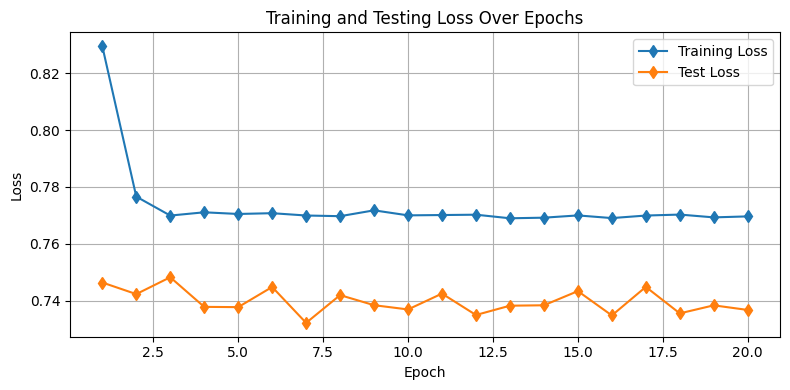

In [28]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCHS + 1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, EPOCHS + 1), test_losses, 'd-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Ok, that wasn't too bad. Let's have a look at the results.

## Making forecasts

To make a forecast with our model, we'll need to pass in a sequence of temperatures with a length equal to that which we used to train our sequence.

For example, we could take a look at a random sequence in the test set:

In [ ]:
# choose a random index
sample_index = 500

X_sample = X_test_tensor[sample_index,:].to(device).unsqueeze(0)
y_sample = y_test_tensor[sample_index,:].to(device).unsqueeze(0)

# make a forecast
model.eval()
with torch.no_grad():
    forecast = model(X_sample)

print(forecaset)


Below, we're going to plot our forecast in both "anomaly space" and in actual temperatures. Let's prepare those vectors here by applying our transformations in reverse:

In [ ]:
# store the samples and forecasts as anomalies
previous_temp_anom = X_sample.cpu().numpy().ravel()
future_temp_anom = y_sample.cpu().numpy().ravel()
forecast_temp_anom = forecast.cpu().numpy().ravel()

# compute the anomalies to real temperatures by applying the climatology
previous_temp = previous_temp_anom + 
future_temp = future_temp_anom + 
forecast_temp = forecast_temp_anom + 

Ok, let's see how our results look:

In [ ]:
fig = plt.figure(figsize=(8,6))

# plto the temp anomalies
plt.subplot(2,1,1)
plt.plot(np.concatenate([previous_temp_anom, future_temp_anom]),
          '-',color='silver',label='Raw')
plt.plot(np.arange(n_previous_days), previous_temp_anom,
         'k.', linewidth=1, label='Input Sequence')
plt.plot(np.arange(n_previous_days, n_previous_days + n_future_days),
         future_temp_anom, 'g.', label='Target Sequence')
plt.plot(np.arange(n_previous_days, n_previous_days + n_future_days),
         forecast_temp_anom, 'b.', label='Predicted Sequence')
plt.ylabel('Temperature\nAnomaly ($^{\\circ}$C)')

# plot the absolute temps
plt.subplot(2,1,2)
plt.plot(np.arange(n_previous_days), previous_temp,
         'k.', linewidth=1, label='Input Sequence')
plt.plot(np.arange(n_previous_days, n_previous_days + n_future_days),
         future_temp, 'g.', label='Target Sequence')
plt.plot(np.arange(n_previous_days, n_previous_days + n_future_days),
         forecast_temp, 'b.', label='Predicted Sequence')
plt.ylabel('Temperature($^{\\circ}$C)')

plt.xlabel('Days since start of timeseries')
plt.legend()
plt.show()

As we can see in the example above, the RNN model captures the general trend in the data, although it does not get the right values. 

The above example is for a forecast, but we can also see how our model does on the entire timeseries. In this example, we will pass in our testing sequences one by one and compare the next output temperature to the real timeseries:

In [ ]:
# make an an array of zeros to fill in with predicted values
predicted_temps_scaled = np.zeros((X_test.shape[0]-n_previous_days,))

# loop through the days to make predictions
with torch.no_grad():
    for i in range(X_test.shape[0]-n_previous_days):
        

Let's see our model is working:

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(predicted_temps_scaled, linewidth=0.5, label='predicted')
plt.plot(temps_anomaly_scaled[-X_test.shape[0]-n_future_days:-n_previous_days-n_future_days], linewidth=0.5, label='true')
plt.ylabel('Normalized Temperature\nAnomaly ($^{\\circ}$C)')
plt.xlabel('Days since start of test timeseries')
plt.legend()
plt.show()

As we can see, the model works pretty well for predicting the temperature on a given day as long as we have the temperatures from the previous days. However, what happens if we try to predict the next 2 years in an autoregressive fashion?

In [ ]:
# make a copy of the scaled temperatures and 
# set the end of the timeseries to 0
predicted_temps_scaled = np.copy(temps_anomaly_scaled)
predicted_temps_scaled[split:]=0

# loop through the days to make autoregressive predictions
with torch.no_grad():
    for i in range(split,len(temps)):
        

Let's see what the prediction looks like:

In [ ]:
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(np.arange(len(temps_anomaly_scaled)), predicted_temps_scaled, label='predicted', linewidth=0.5)
plt.plot(temps_anomaly_scaled[:split], label='true', linewidth=0.5)
plt.legend()
plt.title('Autoegressive Temperature Prediction')
plt.ylabel('Normalized Temperature\nAnomaly ($^{\\circ}$C)')

plt.subplot(2,1,2)
plt.plot(np.arange(len(temps_anomaly_scaled)),
                   predicted_temps_scaled, label='predicted')
plt.plot([split,split],[-4,4],'k--',linewidth=0.5)
plt.text(split,3,'$\\leftarrow$ End of Train Timeseries')
plt.ylim([-4,4])
plt.xlim([split-n_previous_days, split+n_previous_days])
plt.ylabel('Normalized Temperature\nAnomaly ($^{\\circ}$C)')
plt.xlabel('Days since start of timeseries')
plt.show()

Clearly, there is an issue here - why? Well, turns out our little model has learned that it can make fairly good predictions of the weather by returning the mean of the previous 7 days. If you think about the weather around the world, that's actually not a very bad prediction.

However, there is a lot of variability in the weather and the further out we go, the hard it is to make predictions. This is the same reason why we don't trust the weather report much after about a week or so.

**Key Takeaways**
1. A recurrent neural network modifies the feed-forward network structure to include information from past training batches.
2. PyTorch has an implementation of an RNN that can be modified to fit different applications.
3. Autoregressive predictions are hampered by inherent variability.